# Tutorial <span style='color:red'>?</span>: Lorentz Transmission Electron Microscopy

Lorentz Transmission Electron Microscopy (LTEM) is a useful technique to image magnetic structures that exist in thin magnetic samples. In this tutorial, the Ubermag micromagnetic simulation software is used to create 3-Dimensional magnetic structure, from which LTEM of defocused images and electron holography can be obtained. 

It is worth noting that as the Lorentz force depends on ${\bf v}\times {\bf B}$ there is no force along direction of travel of the electron beam, hence Lorentz microscopy is only sensitive to the in-plane magnetic field i.e. the magnetic field perpendicular to the beam.

## LTEM Reference frame

In *exsim* the experimental reference for LTEM is defined by the electron beam propagating along the <span style='color:Red'> negative  </span> $z$ direction.
<span style='color:Red'> Figure?  </span>

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure.

<span style='color:red'>Change to numpy rather than random when we know all is correct</span>

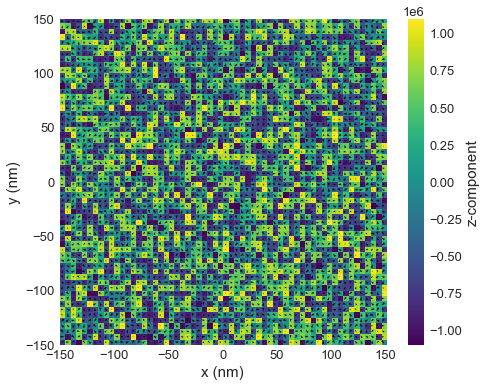

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Relax the system and plot its magnetisation. <span style='color:red'>English vs American Spelling?</span>

Running OOMMF (ExeOOMMFRunner) [2021/07/08 19:05]... (12.0 s)


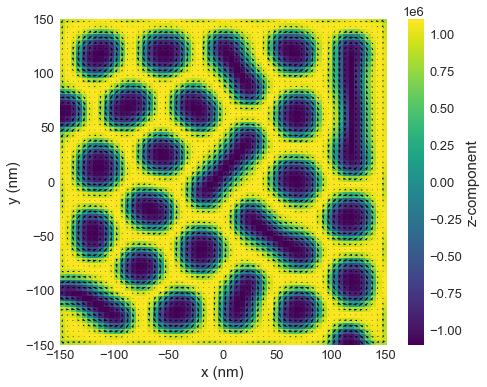

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

Now we have a magnetisation texture we can compute the LTEM defocus and holography patterns.

## Computing LTEM images

<span style='color:red'>Change package name when known</span>
<span style='color:red'>Best way to cite in notebooks? Ask Martin</span>

We can use the <code><span style='color:Red'>exsim</span></code> package to first calculate the phase of the electrons as they propagate through the sample along the $z$ direction.
The phase shift experienced by the electrons as they travel through the sample due to the magnetic contribution is
\begin{equation} \label{Eq:C7:phase_shift_mag}
    \phi_m (x,y)=-\frac{2\pi e}{h}\int_{-\infty}^\infty A_z (x,y,z)\, {\rm d}z,
\end{equation}
where $h$ is Planck's constant and ${\bf A}$ is the magnetic vector potential, as defined in <span style='color:Red'> Ref.~\cite{bleaney2013electricity}. <span>

The calculation of the phase is performed in Fourier space using
\begin{equation} \label{Eq:C7:FT_M}
    \widetilde{\phi}_m (k_x,k_y)=\frac{i e \mu_0 k_\perp^2}{h} \frac{\left[ \widetilde{\bf M}_I(k_x,k_y)\times {\bf k}_\perp \right] _z}{\left( k_\perp^2 + k_c^2 \right)^2},
\end{equation}
where ${\bf M}_I$ is the integrated magnetisation along the path of the electron beam, $\mu_0$ is the vacuum permeability, and $k$ is the k-vector in Fourier space.
To avoid singularities in Fourier space, a Tikhonov filter is used where $1/k^2$ is replaced by $k^2/(k^2+k_c^2)$ where $k_c$ is the radius of the filter.

The function <code><span style='color:red'>exsim</span>.ltem_phase</code> is used to calculate the phase and Fourier transform of the phase. In this function the radius of the Tikhonov filter is defined by <code>kx</code> and <code>ky</code> in units of pixels.

In [3]:
import exsim
kx = ky = 0.1
phase, ft_phase = exsim.ltem.phase(system.m, kx=kx, ky=ky)

The phase and its Fourier transform are <code>discretisedfield</code> objects hence the built in plotting functions can be used to view them. Both the phase and its Fourier transform are complex quantities, hence to view them either the real or imaginary part has to be selected before plotting.

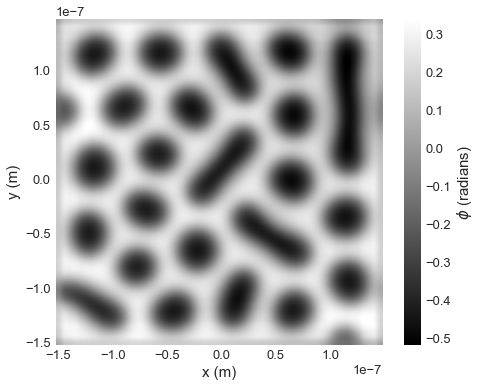

In [4]:
phase.real.mpl_scalar(cmap='gray',
                      interpolation='spline16',
                      colorbar_label=r'$\phi$ (radians)')

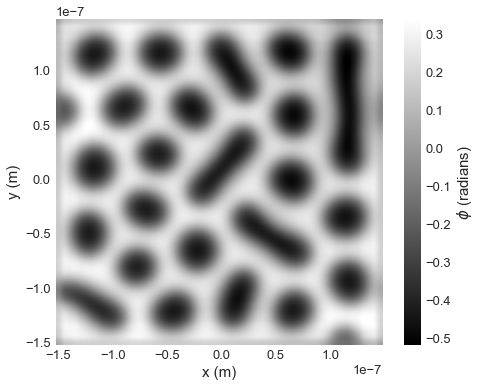

In [5]:
exsim.quick_plots.ltem_phase(system.m)

This example shows how to use the conjugate property to plot $\left\vert\widetilde{\phi}_m\right\vert^2$ with the Tikhonov filter indicated my the small red circle.

<span style='color:red'>Link size of Ellipse to axis so zoom can work well with plotting sections of the ft_phase</span>

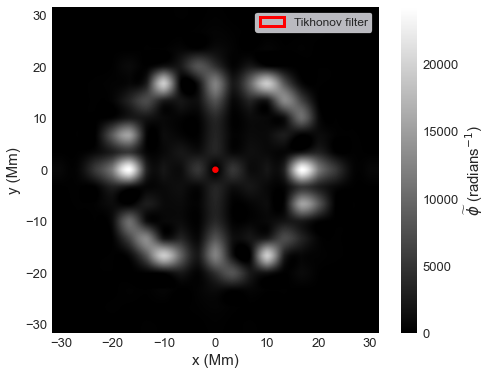

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

centre_region = df.Region(p1=(-30e6, -30e6, 0), p2=(30e6, 30e6, 1))

fig, ax = plt.subplots()
(ft_phase.conjugate * ft_phase)[centre_region].plane('z').real.mpl_scalar(
    ax=ax, cmap='gray', interpolation='spline16', colorbar_label=r'$\widetilde{\phi}$ (radians$^{-1}$)')

multiplier = uu.si_max_multiplier(ft_phase.mesh.region.edges)
ax.add_patch(Ellipse(xy=(0, 0),
                     width=ft_phase.mesh.cell[0] * kx * 2 / multiplier,
                     height=ft_phase.mesh.cell[1] * ky * 2 / multiplier,
                     edgecolor='red',
                     facecolor='none',
                     linewidth=3,
                     label='Tikhonov filter'))
ax.legend(frameon=True);

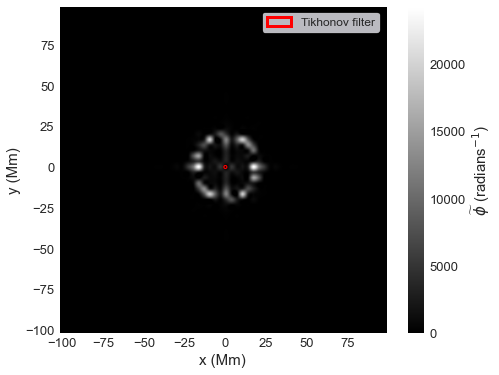

In [7]:
exsim.quick_plots.ltem_ft_phase(system.m)

### Defocused Imaging

The wavefunction of the electron beam as it exits the specimen can be calculated using the phase
\begin{equation}
\psi_0 = e^{i\phi_m}.
\end{equation}

Out-of-focus images can be simulated by propagating the wavefunction through free-space by a distance $\Delta f$, known as the defocus, using Contrast Transfer Function $T$ <span style='color:Red'>(J. E. Bonevich et al., Phys. Rev. B 49, 10, 6800, 1994, E. Hecht,\emph{Optics} 2nd ed. Addison-Wesley, Reading MA, USA 1974)}</span>

\begin{align}
    \psi_{\Delta f} &= {\psi}_{0} * T, \label{Eq:C7:CTF_Wave} \\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 \widetilde{T}({\bf k}), \label{Eq:C7:FT_CTF_Wave}\\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 e^{2 i \pi k^2 (-\frac{1}{2}\lambda \Delta f + \frac{1}{4} C_s \lambda^3 k^2)}. \label{Eq:C7:FT_CTF_Wave_full}
\end{align}
$\lambda$ is the relativistic wavelength of the electrons and $C_s$ is the spherical aberration of the electromagnetic lens.

The image at a specific defocus is then given by
\begin{equation} \label{Eq:C7:Intensity}
    I_{\Delta f} = \left\vert\psi_{\Delta f}\right\vert^2.
\end{equation}

The intensity of an in-focus image is $I=\left\vert\psi_0\right\vert^2=1$ and so the image appears featureless however magnetic contrast appears when you go out-of-focus.

The <code><span style='color:Red'>exsim</span>.ltem_defocus_image</code> function calculates the image at a specific <code>df_length</code>, given the spherical aberration <code>Cs</code>, and accelerating voltage of the electrons <code>U</code>.

In [8]:
defocus = exsim.ltem.defocus_image(phase, U=300e3, Cs=8000, df_length=-0.4e-3)

The defocus image can then be plot using the inbuilt functions.

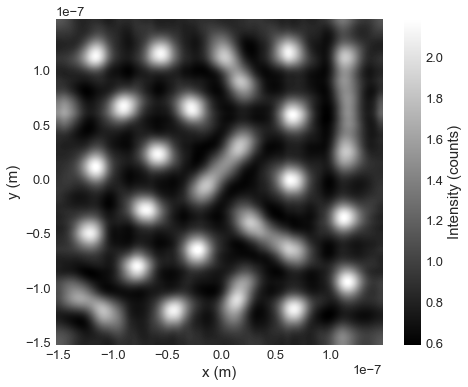

In [9]:
defocus.mpl_scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label='Intensity (counts)')

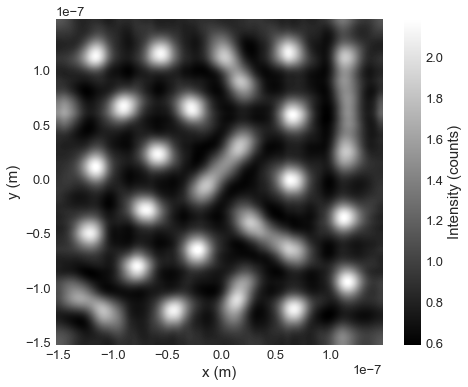

In [11]:
exsim.quick_plots.ltem_defocus(system.m, U=300e3, Cs=8000, df_length=-0.4e-3)

As a rule of thumb, the magnetic feature will only be seen experimentally using this technique if it gives a contrast greater than 1%. The image contrast is defined as
\begin{equation}
{\rm contrast} = \frac{I_{\rm max}-I_{\rm min}}{I_{\rm max} + I_{\rm min}}
\end{equation}
where $I_{\rm max}$ and $I_{\rm max}$ are, respectively, the maximum and minimum intensities of the image.

In [12]:
contrast = (defocus.array.max() - defocus.array.min()) / (defocus.array.max() + defocus.array.min())
print(f'Contrast: {contrast*100:.1f}%')

Contrast: 57.6%


### Off-axis electron holography

Off-axis electron holography the phase of the electrons is recovered directly and may be compared with the phase calculated.

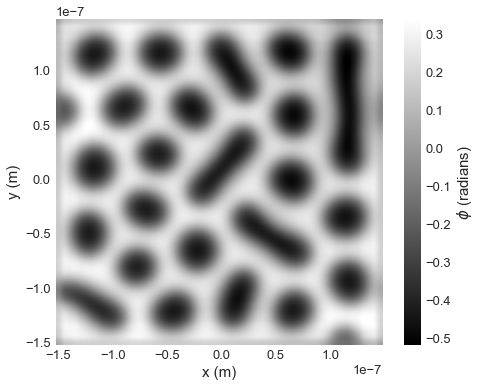

In [13]:
phase.real.mpl_scalar(cmap='gray',
                      interpolation='spline16',
                      colorbar_label=r'$\phi$ (radians)')

### Projected magnetic flux density

From the phase of the electrons determined other useful quantities can be calculated such as the projected magnetic flux density ${\bf B}_\perp$. This can be used to compare against the results from electron holography, as it calculates the phase and hence ${\bf B}_\perp$ is reconstructed. The ${\bf B}_\perp$ can be calculated <span style='color:red'> \cite{beleggia2003electron}</span> from
\begin{equation} \label{Eq:C7:B_perp}
{\bf B}_\perp =\frac{\Phi_0}{\pi t}\begin{pmatrix} -\partial/\partial y \\ \partial/\partial x \end{pmatrix} \phi_m ,
\end{equation}
where $\Phi_0$ is the magnetic flux quantum and $t$ is the thickness of the sample.

<span style='color:red'> describe colour map in more detail. Maybe show sphere?</span>

<span style='color:red'> Think about thickness!</span>

<span style='color:red'> Simpler way for users to calculate projected magnetic flux density? </span>

<span style='color:red'> Is there an easier way to plot the color maps?</span>

<span style='color:red'> Looks like convention is 180 degree rotation of colours</span>

In [10]:
import numpy as np
B_projected = exsim.ltem.integrated_magnetic_flux_density(phase)
B_angle = df.Field(B_projected.mesh, dim=1, value=np.arctan2(B_projected.y.array, B_projected.x.array))
B_plot = B_projected << B_angle
mag = np.sqrt(B_plot.x.array**2 + B_plot.y.array**2)

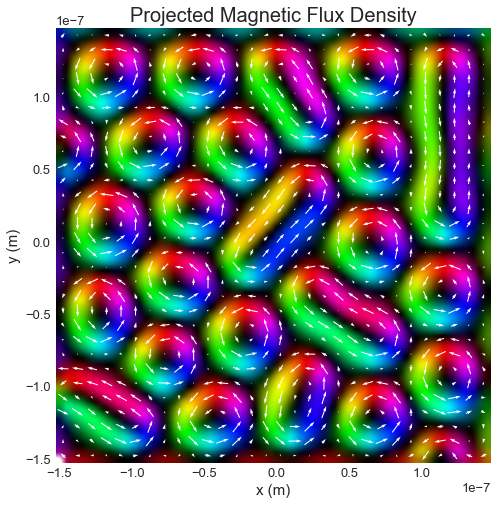

In [11]:
mag[0, 0, 0, 0] = 2 * np.max(mag)  # avoid pure white; "ruins" bottom left corner
lightness = df.Field(B_plot.mesh, dim=1, value=mag)
fig, ax = plt.subplots(figsize=(8,8))
B_plot.z.mpl_scalar(ax=ax,
                    cmap='hsv',
                    interpolation='spline16',
                    lightness_field=lightness,
                    colorbar=False)
B_plot.plane('z', n=(30, 30)).mpl_vector(ax=ax, color='w', use_color=False)
ax.set_title('Projected Magnetic Flux Density');

<span style='color:red'> I think move projected magnetisation into another tutorial which talks about rotations</span>

In [12]:
import numpy as np
m_projection = system.m.project('z')
m_inplane_angle = df.Field(m_projection.mesh, dim=1,
                           value=np.arctan2(m_projection.y.array, m_projection.x.array))

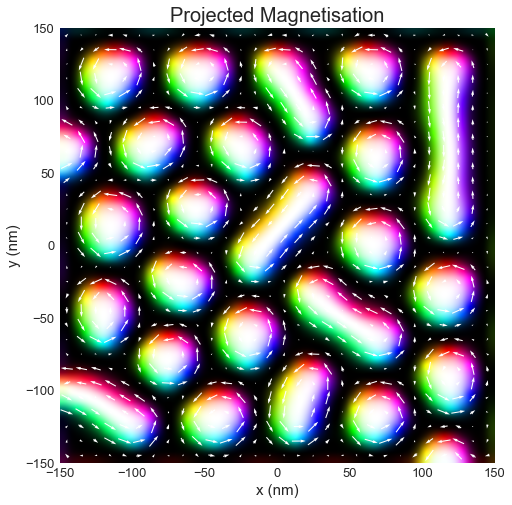

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
m_inplane_angle.mpl_scalar(ax=ax,
                           cmap='hsv',
                           interpolation='spline16',
                           lightness_field=-m_projection.z,
                           colorbar=False)
m_projection.plane('z', n=(30, 30)).mpl_vector(ax=ax,
                                               color='w',
                                               use_color=False)

ax.set_title('Projected Magnetisation');